Pobieranie danych z Kaggle...
Dane przygotowane. Liczba krajów: 156, Liczba cech: 6


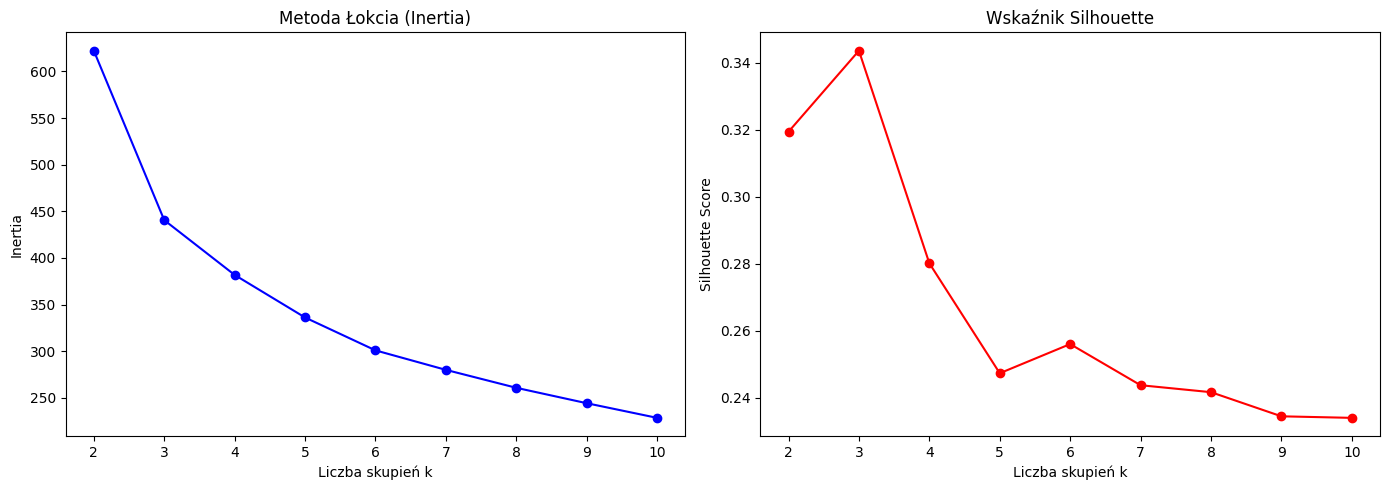


--- Testowanie parametrów DBSCAN ---
eps=0.5, min_samples=3 -> Skupień: 2, Silhouette: 0.199
eps=1.0, min_samples=3 -> Skupień: 4, Silhouette: 0.074
eps=1.0, min_samples=5 -> Skupień: 6, Silhouette: -0.058
eps=1.5, min_samples=3 -> Skupień: 1, Silhouette: 0.279
eps=1.5, min_samples=5 -> Skupień: 1, Silhouette: 0.262


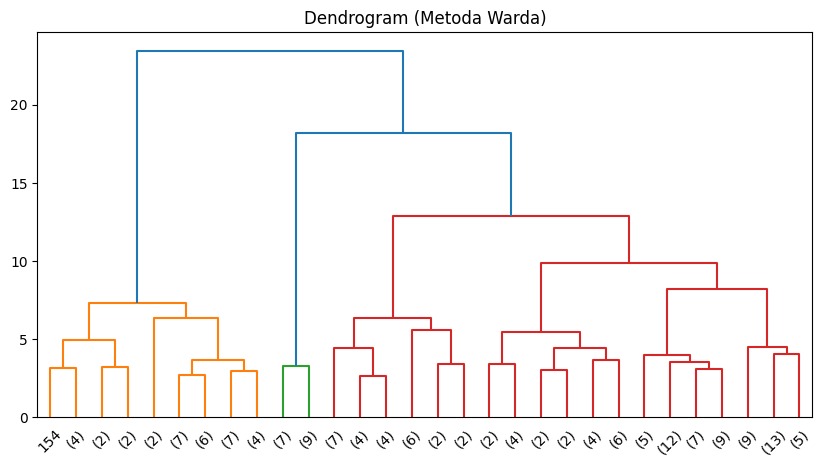


--- Tabela metryk porównawczych ---
           Model  Calinski-Harabasz  Davies-Bouldin  Silhouette
0        K-means          86.022582        1.070299    0.343572
1  Agglomerative          68.226927        1.001875    0.310383


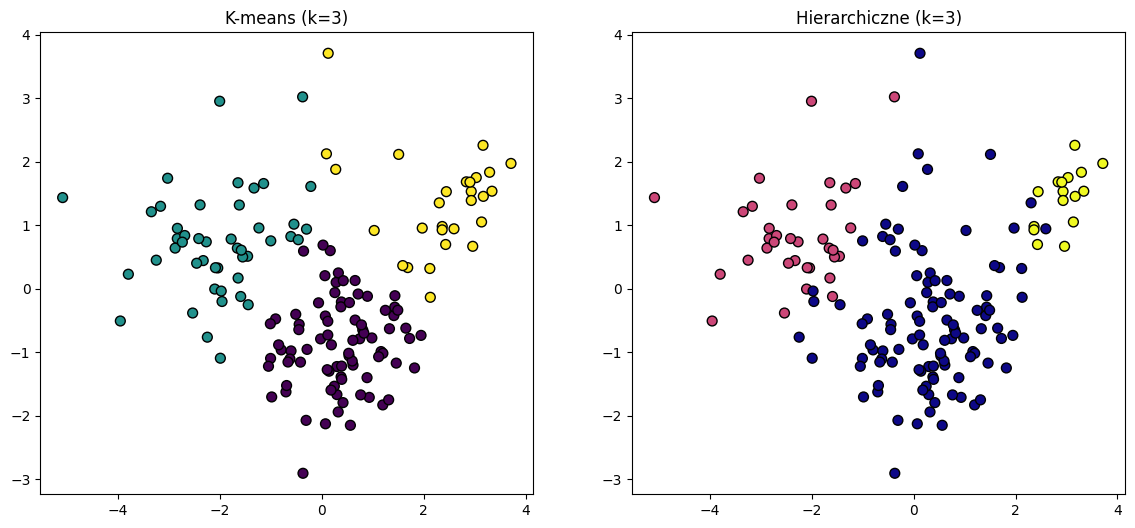

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 2. POBIERANIE I WCZYTANIE DANYCH
# ==========================================
print("Pobieranie danych z Kaggle...")
try:
    path = kagglehub.dataset_download("unsdsn/world-happiness")
    
    # Szukamy wszystkich plików .csv w pobranym folderze
    all_files = glob.glob(os.path.join(path, "*.csv"))
    
    if all_files:
        latest_file = sorted(all_files)[-1] 
        df = pd.read_csv(latest_file)
    else:
        raise FileNotFoundError("Nie znaleziono plików CSV w pobranym zbiorze.")

    # Wybór kolumn numerycznych
    possible_cols = ['GDP per capita', 'Social support', 'Healthy life expectancy', 
                     'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
    
    X_raw = df[possible_cols] if set(possible_cols).issubset(df.columns) else df.select_dtypes(include=[np.number])
    
    X_raw = X_raw.dropna()
    
    # Standaryzacja
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)
    print(f"Dane przygotowane. Liczba krajów: {X.shape[0]}, Liczba cech: {X.shape[1]}")

except Exception as e:
    print(f"WYSTĄPIŁ BŁĄD: {e}")
    X = None

if X is not None:
    # ==========================================
    # 3. K-MEANS: METODA ŁOKCIA I SILHOUETTE
    # ==========================================
    inertia = []
    sil_scores = []
    k_range = range(2, 11)

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        inertia.append(km.inertia_)
        sil_scores.append(silhouette_score(X, labels))

    # Wykresy
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(k_range, inertia, 'bo-')
    ax[0].set_title('Metoda Łokcia (Inertia)')
    ax[0].set_xlabel('Liczba skupień k')
    ax[0].set_ylabel('Inertia')
    
    ax[1].plot(k_range, sil_scores, 'ro-')
    ax[1].set_title('Wskaźnik Silhouette')
    ax[1].set_xlabel('Liczba skupień k')
    ax[1].set_ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    # Finalny model K-means (zakładamy k=3 jako optymalne)
    best_k = 3
    kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    y_kmeans = kmeans_model.fit_predict(X)

    # ==========================================
    # 4. DBSCAN
    # ==========================================
    print("\n--- Testowanie parametrów DBSCAN ---")
    for eps in [0.5, 1.0, 1.5]:
        for min_samples in [3, 5]:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels_db = db.fit_predict(X)
            unique = set(labels_db)
            if len(unique) > 1:
                score = silhouette_score(X, labels_db)
                n_clusters = len(unique) - (1 if -1 in labels_db else 0)
                print(f"eps={eps}, min_samples={min_samples} -> Skupień: {n_clusters}, Silhouette: {score:.3f}")

    # ==========================================
    # 5. METODA HIERARCHICZNA
    # ==========================================
    plt.figure(figsize=(10, 5))
    linked = linkage(X, method='ward')
    dendrogram(linked, truncate_mode='lastp', p=30)
    plt.title('Dendrogram (Metoda Warda)')
    plt.show() 

    agg_model = AgglomerativeClustering(n_clusters=best_k)
    y_agg = agg_model.fit_predict(X)

    # ==========================================
    # 6. OCENA I PORÓWNANIE
    # ==========================================
    metrics_data = []
    for name, labels in [('K-means', y_kmeans), ('Agglomerative', y_agg)]:
        metrics_data.append({
            'Model': name, 
            'Calinski-Harabasz': calinski_harabasz_score(X, labels), 
            'Davies-Bouldin': davies_bouldin_score(X, labels), 
            'Silhouette': silhouette_score(X, labels)
        })
    
    print("\n--- Tabela metryk porównawczych ---")
    results_df = pd.DataFrame(metrics_data)
    print(results_df)

    # ==========================================
    # 7. WIZUALIZACJA PCA (2D)
    # ==========================================
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', s=50)
    plt.title(f'K-means (k={best_k})')
    
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_agg, cmap='plasma', edgecolor='k', s=50)
    plt.title(f'Hierarchiczne (k={best_k})')
    plt.show()